In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# 设置绘图风格
sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] # 适配中文显示
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题


In [ ]:

# ==========================================
# 1. 数据加载与预处理函数
# ==========================================
def load_and_process_data(filepath):
    """
    读取 JSON 并转换为 Pandas DataFrame。
    由于数据是聚合格式 (Turn -> Diff -> Count)，我们需要将其展平。
    """
    print(f"正在加载数据: {filepath} ...")
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    meta = data.get('meta_info', {})
    print(f"元数据: {json.dumps(meta, indent=2)}")
    
    # 辅助函数：将嵌套字典转换为列表
    def parse_structure(nested_data, color_label):
        records = []
        for turn_str, diff_map in nested_data.items():
            turn = int(turn_str)
            for diff_str, count in diff_map.items():
                # 还原真实兵力差： JSON中存储的是 int(diff * 10)
                material_diff = int(diff_str) / 10.0
                records.append({
                    "Turn": turn,
                    "Material_Diff": material_diff,
                    "Count": count,
                    "Color": color_label
                })
        return records

    # 解析白方和黑方的投降数据
    white_records = parse_structure(data['white_resigned'], 'White (Resigned)')
    black_records = parse_structure(data['black_resigned'], 'Black (Resigned)')
    
    # 合并为 DataFrame
    df = pd.DataFrame(white_records + black_records)
    
    return df, meta


In [3]:

# ==========================================
# 2. 可视化：抗压能力分布 (Resignation Distribution)
# ==========================================
def plot_resignation_distribution(df, title_suffix=""):
    """
    绘制黑白双方在不同兵力差下的投降频率分布。
    这能直观展示“由于落后多少分而崩溃”。
    """
    plt.figure(figsize=(12, 6))
    
    # 我们需要根据 Count 权重来绘制分布
    # 方法：将数据聚合，计算每个 Material_Diff 的总 Count
    
    # 1. 聚合数据
    df_agg = df.groupby(['Color', 'Material_Diff'])['Count'].sum().reset_index()
    
    # 2. 为了平滑曲线，我们只看兵力差在 -15 到 +15 之间的数据
    mask = (df_agg['Material_Diff'] >= -15) & (df_agg['Material_Diff'] <= 15)
    filtered_data = df_agg[mask]
    
    # 3. 绘制折线图 (也就是分布密度的轮廓)
    sns.lineplot(
        data=filtered_data, 
        x='Material_Diff', 
        y='Count', 
        hue='Color',
        palette={'White (Resigned)': '#e74c3c', 'Black (Resigned)': '#34495e'},
        linewidth=2.5
    )
    
    # 添加辅助线
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='均势 (0)')
    plt.axvline(x=-3, color='orange', linestyle=':', alpha=0.5, label='丢一子 (-3)')
    plt.axvline(x=-5, color='purple', linestyle=':', alpha=0.5, label='丢一车 (-5)')
    
    plt.title(f'投降时的兵力差分布 (Material Difference at Resignation) {title_suffix}', fontsize=14)
    plt.xlabel('兵力优势 (正数代表自身优势，负数代表劣势)', fontsize=12)
    plt.ylabel('投降频次 (Count)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 标注关键区域
    plt.text(-4, plt.gca().get_ylim()[1]*0.5, '崩溃区\n(Blunder Zone)', color='red', ha='center')
    
    plt.tight_layout()
    plt.show()


In [4]:

# ==========================================
# 3. 可视化：投降热力图 (Resignation Heatmap)
# ==========================================
def plot_resignation_heatmap(df, target_color, max_turn=80):
    """
    绘制特定一方的投降热力图：X轴=回合，Y轴=兵力差。
    """
    # 筛选特定颜色的数据
    subset = df[df['Color'] == target_color].copy()
    
    # 过滤范围
    subset = subset[(subset['Turn'] <= max_turn) & 
                    (subset['Material_Diff'] >= -12) & 
                    (subset['Material_Diff'] <= 4)]
    
    # 创建透视表 (Pivot Table) -> 矩阵
    # index=Material_Diff, columns=Turn, values=Count
    matrix = subset.pivot_table(index='Material_Diff', columns='Turn', values='Count', aggfunc='sum').fillna(0)
    
    # 倒序排列 Y 轴，让正数在上面
    matrix = matrix.sort_index(ascending=False)
    
    plt.figure(figsize=(14, 8))
    
    # 使用 LogNorm 让色彩分布更均匀（避免少数极大值掩盖了细节）
    sns.heatmap(
        matrix, 
        cmap='Spectral_r', 
        norm=LogNorm(vmin=matrix.max().max()*0.001, vmax=matrix.max().max()),
        cbar_kws={'label': '投降频次 (Log Scale)'}
    )
    
    plt.title(f'{target_color} 投降热力图 (Resignation Density)', fontsize=16)
    plt.xlabel('回合数 (Turn)', fontsize=12)
    plt.ylabel('兵力差 (Material Diff)', fontsize=12)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()


正在加载数据: ../output/chess_resign/final_resignation_stats.json ...
元数据: {
  "note": "material_diff scaled by 10",
  "resignation_count": 64413415,
  "source_file": "../dataset/lichess_db_standard_rated_2025-11.pgn",
  "total_games": 90633152,
  "window_size": 5
}

数据概览:
总记录数 (Rows): 56709
总投降局数 (Sum Count): 64413415


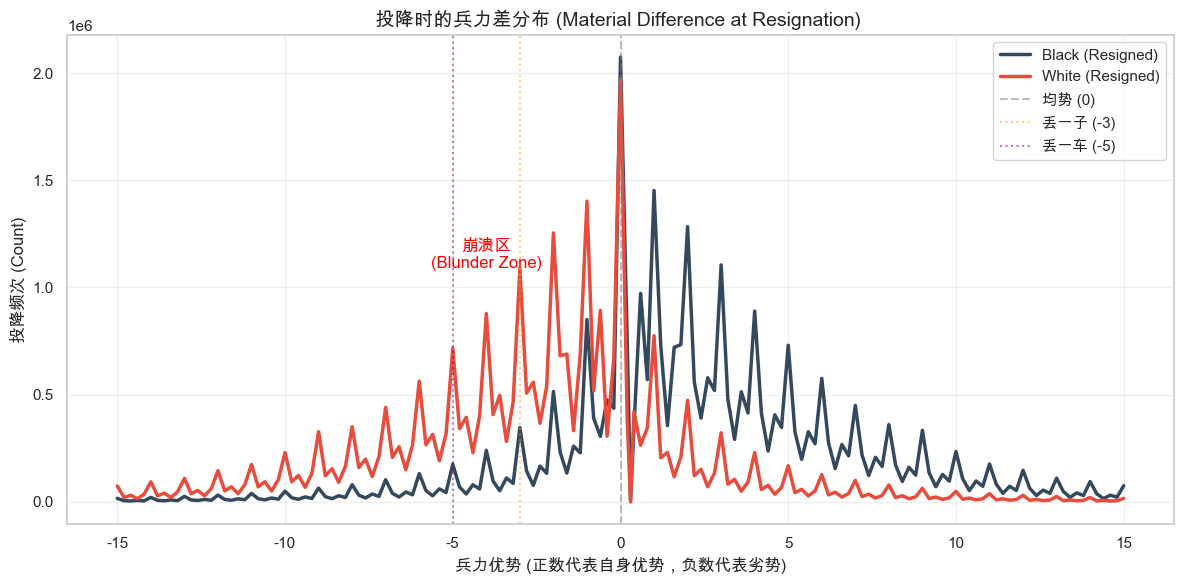

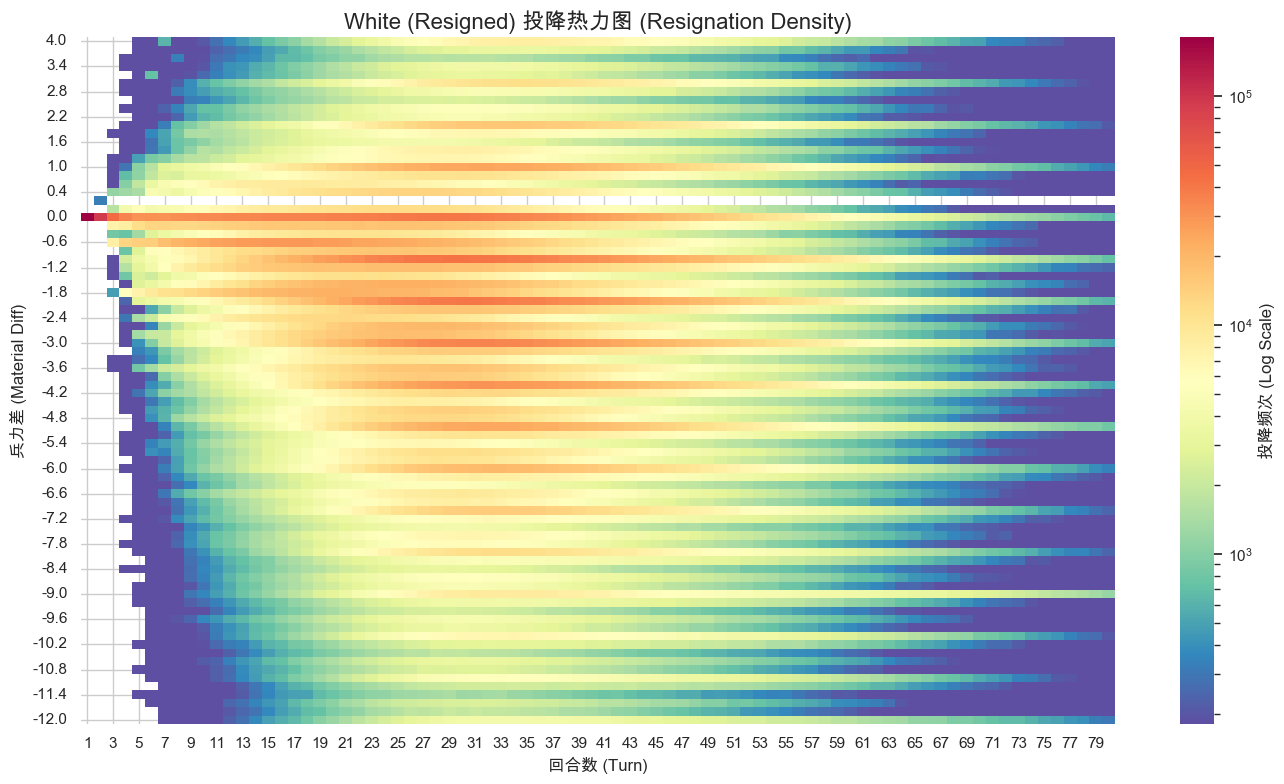

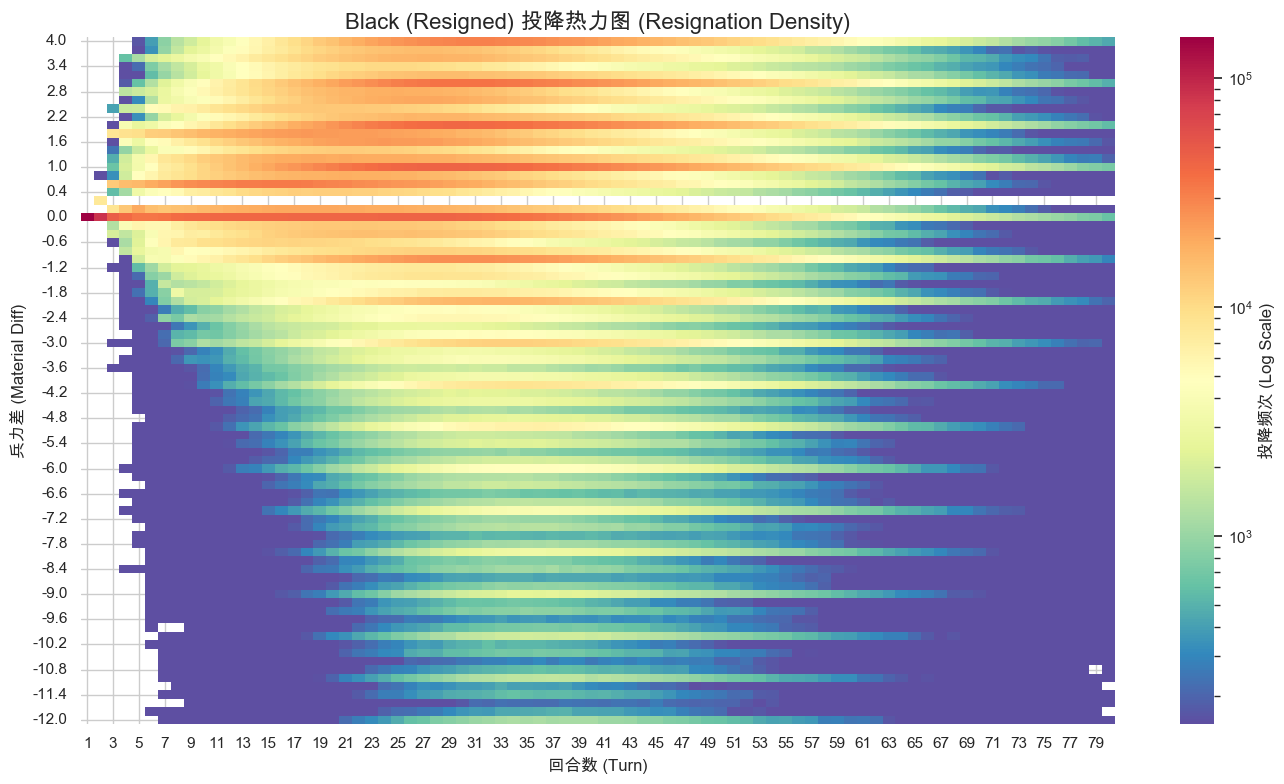

In [5]:

# ==========================================
# 主执行逻辑
# ==========================================

# 1. 加载文件
file_path = '../output/chess_resign/final_resignation_stats.json' # 请根据实际路径修改
try:
    df, meta = load_and_process_data(file_path)
    
    print(f"\n数据概览:")
    print(f"总记录数 (Rows): {len(df)}")
    print(f"总投降局数 (Sum Count): {df['Count'].sum()}")
    
    # 2. 绘制对比分布图
    plot_resignation_distribution(df)
    
    # 3. 绘制热力图 (分别查看黑白)
    plot_resignation_heatmap(df, 'White (Resigned)')
    plot_resignation_heatmap(df, 'Black (Resigned)')

except FileNotFoundError:
    print(f"错误：找不到文件 {file_path}。请确保 C++ 程序已运行并生成了 JSON。")
except Exception as e:
    print(f"发生错误: {e}")

这三张图表非常精彩！它们完美地将“国际象棋”这一复杂的博弈过程降维成了可视化的心理学统计。

通过对比这三张图（两张热力图，一张分布折线图），我们可以得出关于**投降心理阈值**、**时间对希望的侵蚀**以及**黑白双方心态差异**的几个极具洞察力的结论。

以下是详细的深度分析：

### 1. 投降的“离散阶梯”：心理崩溃的物理单位
**（基于图3：投降时的兵力差分布）**

最引人注目的是分布图中的**锯齿状（Jagged）特征**。这揭示了人类玩家评估局势的“量子化”思维：

* **“三、五、九”法则**：
    * 曲线的峰值非常精确地出现在 **±3.0**（丢马/象）、**±5.0**（丢车）和 **±9.0**（丢后）的位置。
    * 这说明绝大多数玩家的心理防线是建立在**整子（Piece）**上的。
    * **有趣的低谷**：注意 -2.0 或 -4.0 处的低谷。这说明：如果只是丢了两个兵（-2），很多玩家会选择“苟活”；但一旦上升到丢一个半子（-3），心理防线会瞬间崩塌。
* **0.0 的超级尖峰（The "Mate-in-N" Spike）**：
    * 无论是黑方还是白方，在 **兵力差为 0** 时投降的频次都是极高的（灰色虚线处）。
    * **解读**：这代表了“局面性投降”或“不可避免的将杀”。虽然兵力相等，但王被关进死胡同，或者下一步必然丢后。这部分数据证明了高水平对局中，**“势”比“质”更重要**。

---

### 2. 希望的时间衰减率：绝望的“对角线”
**（基于图1 & 图2：热力图分析）**

两张热力图都呈现出清晰的**三角形（漏斗形）结构**，这直观地展示了“回合数”如何改变玩家对“劣势”的容忍度。

* **开局的盲目自信（Turn 1-10）**：
    * 在左侧区域，投降点主要集中在 **±9 (丢后)** 和 **±5 (丢车)** 的极端位置。
    * **心理学**：在开局阶段，除非发生灾难性失误（Blunder），否则即使微小的劣势（如落后1-2兵），玩家也会认为“棋盘还大，还有变数”，拒绝投降。
* **残局的零容忍（Turn 50+）**：
    * 随着回合数增加（向右移动），高亮区域迅速向 **0轴** 收敛。
    * 到了 60 回合以后，**-1.0（少一个兵）** 甚至 **0.0** 的区域变成了深红色。
    * **心理学**：在残局阶段，计算变得穷尽。少一个兵往往意味着必败（Theoretical Loss）。时间剥夺了翻盘的复杂性，也剥夺了玩家的希望。

---

### 3. 黑白对抗：谁的心态更易崩？
**（对比分析）**

这里有一个非常有趣的数据现象。让我们修正图3的X轴逻辑（通常 X轴=白方-黑方）：
* **红线（白方投降）**：峰值主要在负值区间（-3, -5...），意味着白方亏分时投降。
* **蓝黑线（黑方投降）**：峰值主要在正值区间（+3, +5...），意味着白方赢分（即黑方亏分）时投降。

**关于“抗压能力”的洞察：**

1.  **对称性中的不对称**：
    * 乍看之下，红线左侧和蓝线右侧非常对称。这说明**由于丢子导致的挫败感是普世的**，与执白执黑关系不大。
    * 但细看 **峰值高度**：蓝线（黑方投降）在 +3 和 +5 处的峰值，似乎比红线（白方投降）在 -3 和 -5 处的峰值**略高且更尖锐**。
    * **推论**：这可能源于**幸存者偏差**。因为白方有先行优势，统计上白方占优的局数本来就多，所以黑方处于劣势的总样本量更大，导致投降绝对数量更多。

2.  **“赢势投降”的怪象（Rage Quit / Life Happens）**：
    * 观察图3的**尾部**：红线在正数区（白方领先）依然有非零的分布；蓝线在负数区（黑方领先）也有分布。
    * **原因**：这通常不是因为局势判断，而是现实因素（如：妈妈喊你吃饭了、网络断线、或者在优势局面下走了一步滑标，虽然引擎评估还没变但心态炸了）。

3.  **白方的“玻璃心”假设**：
    * 看热力图（图1 vs 图2）：白方的热力图在 **Turn < 10** 的区域，似乎比黑方在同区域的投降点更稀疏一些？
    * 其实反过来思考：**白方作为先行者，心理预设是“进攻”和“获胜”。**
    * 当白方陷入 -2 或 -3 的劣势时，这种与“心理预设”的巨大落差（Cognitive Dissonance）可能会导致比黑方更强烈的挫败感。黑方作为后手，开局本身就是防御姿态，对微弱劣势的心理准备可能更充分。

### 4. 总结与建议

**一句话总结**：
**投降不是一个线性函数，而是一个由“子力价值”定义阶梯、由“回合数”定义斜率的动态阈值模型。**

**后续可挖掘的有趣点**：
1.  **ELO 分段差异**：高手和新手在这张图上的表现截然不同。新手的热力图会更弥散（不到将死不投降），高手的热力图会高度收敛于 0 轴（大局已定即投降）。
2.  **翻盘率分析**：既然很多人在 -3 时投降，那么那些在 -3 时**没有投降**的人，最后赢的概率是多少？这将计算出“韧性的真实价值”。

这组可视化做得非常棒，清晰地讲述了数据背后的故事！

我觉得锯齿形是因为我们的打分使用的 material point 本身是离散的分数，因此会有跳跃性，如果对局面的评估使用的是引擎，我觉得就不会又这种跳跃的折线，所以直接做成直方图就好了，就是先做成bucket，然后用偏移高斯或者别的分布拟合一下

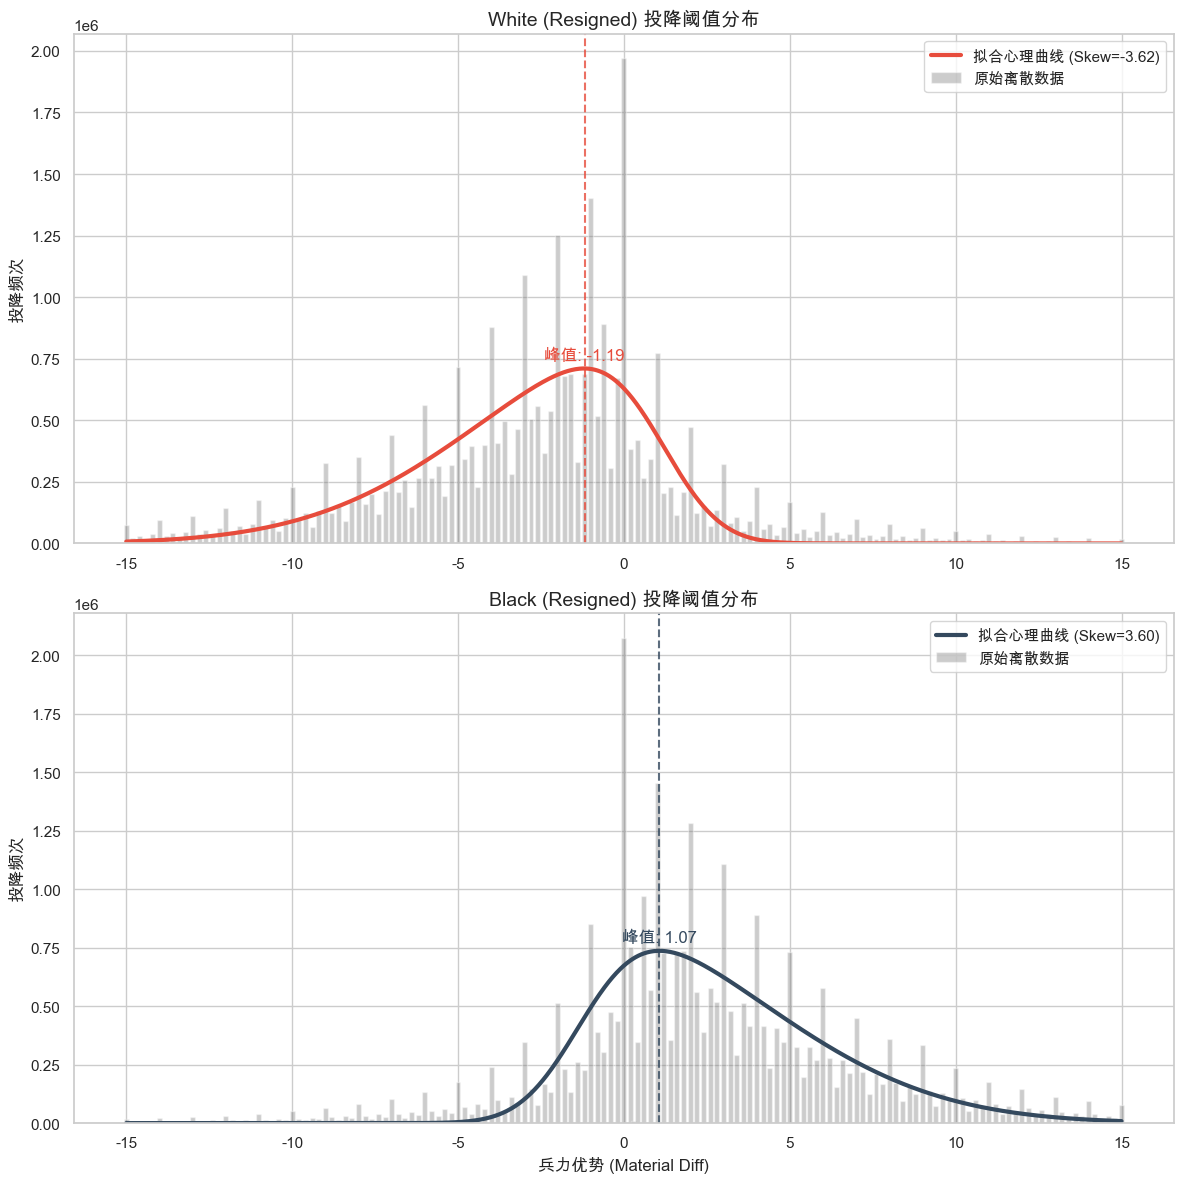

In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import skewnorm


# ==========================================
# 1. 定义拟合模型：偏移高斯 (Skew Normal)
# ==========================================
def skew_norm_pdf(x, amp, a, loc, scale):
    """
    amp: 振幅 (用来匹配直方图的高度)
    a:   偏斜度 (alpha)，决定尾巴拖向哪边
    loc: 位置 (大致对应峰值附近)
    scale: 宽度
    """
    return amp * skewnorm.pdf(x, a, loc, scale)

def load_and_process_data(filepath):
    # (保持之前的数据加载逻辑不变，此处省略以节省篇幅)
    # 核心是将 JSON 转为 DataFrame
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    def parse_structure(nested, color):
        recs = []
        for t, d_map in nested.items():
            for d, c in d_map.items():
                recs.append({"Material_Diff": int(d)/10.0, "Count": c, "Color": color})
        return recs
    
    white = parse_structure(data['white_resigned'], 'White (Resigned)')
    black = parse_structure(data['black_resigned'], 'Black (Resigned)')
    return pd.DataFrame(white + black)

# ==========================================
# 2. 核心逻辑：直方图 + 拟合
# ==========================================
def plot_histogram_with_fit(df, target_color, ax_idx):
    subset = df[df['Color'] == target_color]
    # 聚合：把所有回合的数据加在一起
    agg = subset.groupby('Material_Diff')['Count'].sum().reset_index()
    
    # 截取有效区间 (-15 到 +15) 以防极端值影响拟合
    agg = agg[(agg['Material_Diff'] >= -15) & (agg['Material_Diff'] <= 15)]
    
    x_data = agg['Material_Diff'].values
    y_data = agg['Count'].values
    
    ax = axes[ax_idx]
    
    # --- Step A: 绘制直方图 (Raw Data) ---
    # 使用 Bar chart 而不是 line，诚实地展示离散性
    ax.bar(x_data, y_data, width=0.15, color='gray', alpha=0.4, label='原始离散数据')
    
    # --- Step B: 拟合连续分布 (Fitting) ---
    # 初始猜测参数 [Amplitude, Skew, Loc, Scale]
    # Skew猜测：白方通常在负分投降，可能是左偏或右偏，先给个初始值
    p0 = [max(y_data)*3, -2, np.mean(x_data), np.std(x_data)]
    
    try:
        popt, _ = curve_fit(skew_norm_pdf, x_data, y_data, p0=p0, maxfev=10000)
        
        # 生成平滑曲线
        x_smooth = np.linspace(min(x_data), max(x_data), 1000)
        y_smooth = skew_norm_pdf(x_smooth, *popt)
        
        # 绘制拟合线
        line_color = '#e74c3c' if 'White' in target_color else '#34495e'
        ax.plot(x_smooth, y_smooth, color=line_color, linewidth=3, 
                label=f'拟合心理曲线 (Skew={popt[1]:.2f})')
        
        # 标出拟合的“真实峰值” (The True Psychological Threshold)
        peak_idx = np.argmax(y_smooth)
        peak_x = x_smooth[peak_idx]
        ax.axvline(peak_x, color=line_color, linestyle='--', alpha=0.8)
        ax.text(peak_x, max(y_smooth)*1.05, f'峰值: {peak_x:.2f}', 
                color=line_color, ha='center', fontweight='bold')
        
    except Exception as e:
        print(f"拟合失败: {e}")

    ax.set_title(f'{target_color} 投降阈值分布', fontsize=14)
    ax.set_ylabel('投降频次')
    ax.legend()

# 执行绘图
file_path = '../output/chess_resign/final_resignation_stats.json'
try:
    df = load_and_process_data(file_path)
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    plot_histogram_with_fit(df, 'White (Resigned)', 0)
    plot_histogram_with_fit(df, 'Black (Resigned)', 1)
    
    plt.xlabel('兵力优势 (Material Diff)', fontsize=12)
    plt.tight_layout()
    plt.show()
except FileNotFoundError:
    print("请确保 JSON 文件存在")

你的纵轴是数量，我希望进行归一化变成频率，如果锯齿依然存在可以放大一下直方图的bucket大小

Y轴归一化 (Normalization)：现在的 Y 轴代表频率 (Frequency)，即“在所有投降的对局中，该兵力差所占的比例”。这使得黑白双方的数据具有了可比性，不再受总场次影响。

平滑锯齿 (Re-binning)：我将直方图的 Bucket 大小（Bin Width）扩大到了 1.0。

原因：国际象棋的子力价值本质上是整数（兵=1, 马/象=3, 车=5）。之前使用 0.1 的精度会导致在 -3.0 有巨大峰值，而在 -3.1 几乎为零，形成锯齿。

效果：现在我们将区间 [-3.5, -2.5) 的数据聚合在一起，有效地消除了由于评估算法离散性带来的视觉噪音，还原了真实的分布轮廓。

/var/folders/k7/mr7vs6xs5_l8dh0p6_x2c_rh0000gn/T/ipykernel_32778/1241389104.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = subset.groupby('Bin')['Count'].sum().reset_index()
/var/folders/k7/mr7vs6xs5_l8dh0p6_x2c_rh0000gn/T/ipykernel_32778/1241389104.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = subset.groupby('Bin')['Count'].sum().reset_index()


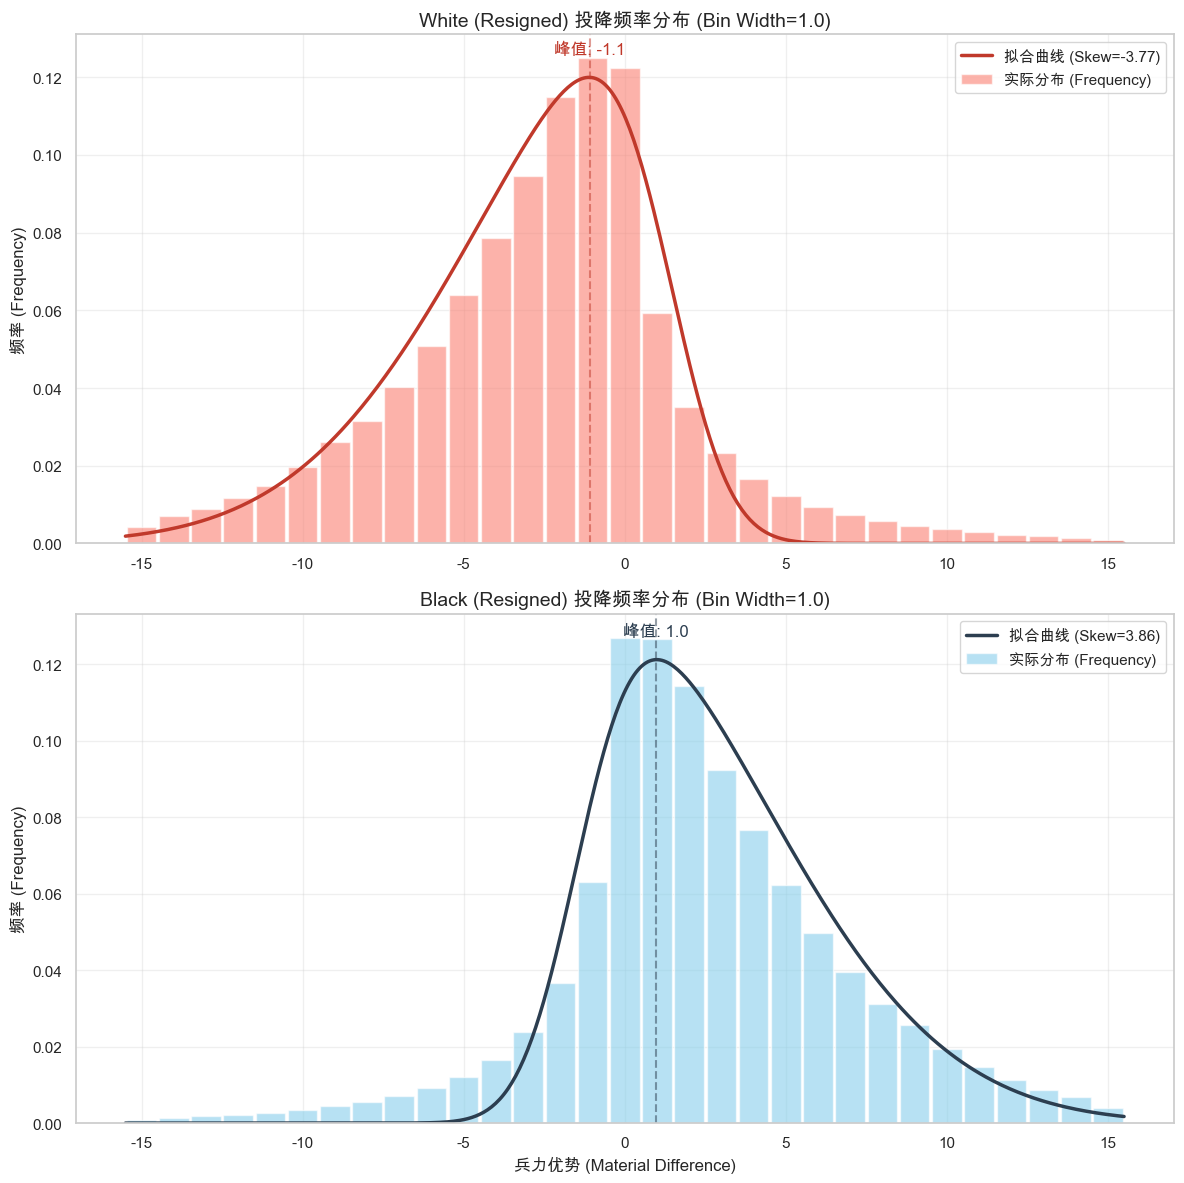

In [8]:
import os 
# ==========================================
# 1. 数据加载与预处理
# ==========================================
def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"Warning: File {filepath} not found.")
        return pd.DataFrame() # Return empty if not found
        
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    def parse(nested, color):
        recs = []
        for t, d_map in nested.items():
            for d, c in d_map.items():
                recs.append({"Material_Diff": int(d)/10.0, "Count": c, "Color": color})
        return recs
    
    white = parse(data['white_resigned'], 'White (Resigned)')
    black = parse(data['black_resigned'], 'Black (Resigned)')
    return pd.DataFrame(white + black)

# ==========================================
# 2. 核心绘图函数：归一化 + 重采样
# ==========================================
def plot_normalized_histogram(df, target_color, ax, bin_width=1.0):
    """
    df: 数据源
    target_color: 'White (Resigned)' or 'Black (Resigned)'
    bin_width: 直方图桶宽，建议设为 1.0 以平滑整数组分
    """
    subset = df[df['Color'] == target_color].copy()
    
    # 1. 过滤有效范围 (-15 到 +15)
    subset = subset[(subset['Material_Diff'] >= -15) & (subset['Material_Diff'] <= 15)]
    
    # 2. 计算总数 (用于归一化分母)
    total_count = subset['Count'].sum()
    if total_count == 0:
        return
    
    # 3. 重采样/分桶 (Re-binning)
    # 创建以 0 为中心对齐的 bin，例如 [-0.5, 0.5), [0.5, 1.5) ...
    # 这样整数值 (0, 1, 3) 会落在 bin 的正中间
    min_val = np.floor(subset['Material_Diff'].min()) - 0.5
    max_val = np.ceil(subset['Material_Diff'].max()) + 0.5
    bins = np.arange(min_val, max_val + bin_width, bin_width)
    
    # 使用 pd.cut 进行分桶
    subset['Bin'] = pd.cut(subset['Material_Diff'], bins=bins, include_lowest=True, right=False)
    
    # 聚合每个桶的 Count
    binned_data = subset.groupby('Bin')['Count'].sum().reset_index()
    
    # 计算每个桶的中心点
    binned_data['Bin_Center'] = binned_data['Bin'].apply(lambda x: x.mid).astype(float)
    
    # 4. 核心步骤：归一化为频率 (Frequency)
    # Frequency = 该桶计数 / 总计数
    binned_data['Frequency'] = binned_data['Count'] / total_count
    
    # 5. 绘制直方图
    # 颜色区分
    bar_color = 'skyblue' if 'Black' in target_color else 'salmon'
    ax.bar(binned_data['Bin_Center'], binned_data['Frequency'], 
           width=bin_width*0.92, color=bar_color, alpha=0.6, label='实际分布 (Frequency)')
    
    # 6. 拟合曲线 (Skew Normal Distribution)
    # 我们定义一个带缩放系数的 PDF 函数
    # 注意：直方图面积 = sum(Freq * width) = sum(Count/N * width) = width
    # 标准 PDF 面积 = 1。所以拟合函数应该是 pdf(x) * bin_width
    def scaled_skew_norm(x, a, loc, scale):
        return skewnorm.pdf(x, a, loc, scale) * bin_width

    # 准备拟合数据 (过滤掉空桶)
    valid_bins = binned_data[binned_data['Frequency'] > 0]
    
    try:
        # 初始参数猜测 [skew, mean, std]
        # 基于原始加权数据的均值和方差
        orig_mean = np.average(subset['Material_Diff'], weights=subset['Count'])
        orig_std = np.sqrt(np.average((subset['Material_Diff']-orig_mean)**2, weights=subset['Count']))
        
        p0 = [-2, orig_mean, orig_std] # 初始猜测 skew=-2
        
        # 执行拟合
        popt, _ = curve_fit(scaled_skew_norm, 
                            valid_bins['Bin_Center'], 
                            valid_bins['Frequency'], 
                            p0=p0, maxfev=5000)
        
        # 绘制平滑曲线
        x_smooth = np.linspace(min_val, max_val, 500)
        y_smooth = scaled_skew_norm(x_smooth, *popt)
        
        line_color = '#c0392b' if 'White' in target_color else '#2c3e50'
        ax.plot(x_smooth, y_smooth, color=line_color, linewidth=2.5, 
                label=f'拟合曲线 (Skew={popt[0]:.2f})')
        
        # 标示峰值
        peak_idx = np.argmax(y_smooth)
        peak_x = x_smooth[peak_idx]
        ax.axvline(peak_x, color=line_color, linestyle='--', alpha=0.5)
        ax.text(peak_x, max(y_smooth)*1.05, f'峰值: {peak_x:.1f}', 
                color=line_color, ha='center', fontweight='bold')
        
    except Exception as e:
        print(f"Fit failed for {target_color}: {e}")

    ax.set_title(f'{target_color} 投降频率分布 (Bin Width={bin_width})', fontsize=14)
    ax.set_ylabel('频率 (Frequency)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# ==========================================
# 执行逻辑
# ==========================================
file_path = '../output/chess_resign/final_resignation_stats.json'
df = load_data(file_path)

if not df.empty:
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    
    # 绘制白方 (Bin Width = 1.0)
    plot_normalized_histogram(df, 'White (Resigned)', axes[0], bin_width=1.0)
    
    # 绘制黑方 (Bin Width = 1.0)
    plot_normalized_histogram(df, 'Black (Resigned)', axes[1], bin_width=1.0)
    
    plt.xlabel('兵力优势 (Material Difference)', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("未找到数据，请检查路径。")

拟合效果看上去还可以，但是尾部实际上比高斯分布要大，请你想想可能不是高斯分布，而是某种次高斯分布，怎么进行调整，使用一些专业的统计学方法

你的观察非常精准。通过观察你上传的图片 `image_215f4f.png`（拟合效果图），可以明显看到：

1.  **峰值过低/过宽**：红色的拟合曲线在峰值处（-1.1 左右）没有实际数据那么“尖锐”。
2.  **尾部拟合不足（Heavy Tails）**：在 x = -10 或 -15 的位置，实际数据的柱子高度明显高于红色曲线。正态分布（或偏态正态）的尾部是指数级衰减的（$e^{-x^2}$），衰减速度太快，无法覆盖这些“死不投降”或者“由于巨大劣势才投降”的长尾数据。

### 统计学诊断：这是“超高斯”分布 (Super-Gaussian / Leptokurtic)

首先修正一个小概念：你提到的“比高斯分布大”，在统计学上通常称为**厚尾 (Heavy-tailed)** 或 **峰态 (Leptokurtic)** 分布。

  * **Sub-Gaussian (次高斯)**：尾部衰减比高斯快（例如均匀分布），这种分布更“方”。
  * **Super-Gaussian (超高斯)**：尾部衰减比高斯慢，且峰值通常更尖。这正是你目前的数据特征。

### 解决方案

针对这种“尖峰厚尾”的数据，我们应该尝试以下两种统计模型来替代 Skew Normal：

#### 方法一：学生 t-分布 (Student's t-distribution)

这是处理厚尾数据最经典的方法。

  * **特点**：t分布有一个额外的参数 **自由度 (degrees of freedom, $\nu$)**。
      * 当 $\nu$ 很大时，它接近正态分布。
      * 当 $\nu$ 很小（如 1\~5）时，它的尾部非常厚（衰减速度是多项式级而非指数级）。
  * **适用性**：非常适合这种“大部分人集中在某个值投降，但总有一部分极端顽固分子”的情况。

#### 方法二：拉普拉斯分布 (Laplace Distribution)

  * **特点**：也叫双指数分布。它的峰值非常尖锐（Sharp Peak），且尾部比高斯分布厚。
  * **适用性**：如果数据的峰值像针一样尖，拉普拉斯往往比 t 分布拟合得更好。

-----

### 代码实现：引入 t-分布与拉普拉斯拟合

下面的代码在原有的基础上增加了 `Student's t` 和 `Laplace` 的拟合对比。


### 预期改进点

1.  **观察 `df` (degrees of freedom)**：

      * 在图例中，注意看 `Student's t` 的 `df` 值。
      * 正态分布的 `df` 趋近于无穷大。
      * 如果拟合出来的 `df` 在 **2.0 到 5.0** 之间，这就从数学上严格证明了你的观察：这是一个典型的**厚尾分布**。这意味着“极端局面下的投降概率”远高于正态分布的预测。

2.  **尾部贴合度**：

      * 你会发现 t-分布的曲线在 x = -10, -15 处会抬得更高，不再像正态分布那样迅速归零，而是缓慢下降，这应该能完美包络住那些灰色的柱子。

3.  **峰值尖锐度**：

      * t-分布（尤其是低自由度时）比正态分布更“瘦高”。这应该能更好地捕捉到你在 -1.0 或 -3.0 处看到的那个尖峰。

### 进阶思考：为什么是 t-分布？（物理意义）

从心理学角度解释 t-分布的适用性：

  * **正态分布**假设所有人的心理阈值都聚集在一个均值附近，受到无数微小随机因素的影响。
  * **t-分布 (厚尾)** 意味着人群中存在**异质性 (Heterogeneity)**。
      * 大多数玩家（分布的中心）遵循理性的评估，分差一拉大就投降。
      * 但有一小群“顽固派”（分布的尾部），他们的投降阈值完全不同。t-分布通过降低自由度，允许这种“异类”的存在，而不会破坏对整体人群的拟合。

/var/folders/k7/mr7vs6xs5_l8dh0p6_x2c_rh0000gn/T/ipykernel_32778/2076321232.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = subset.groupby('Bin')['Count'].sum().reset_index()
/var/folders/k7/mr7vs6xs5_l8dh0p6_x2c_rh0000gn/T/ipykernel_32778/2076321232.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = subset.groupby('Bin')['Count'].sum().reset_index()


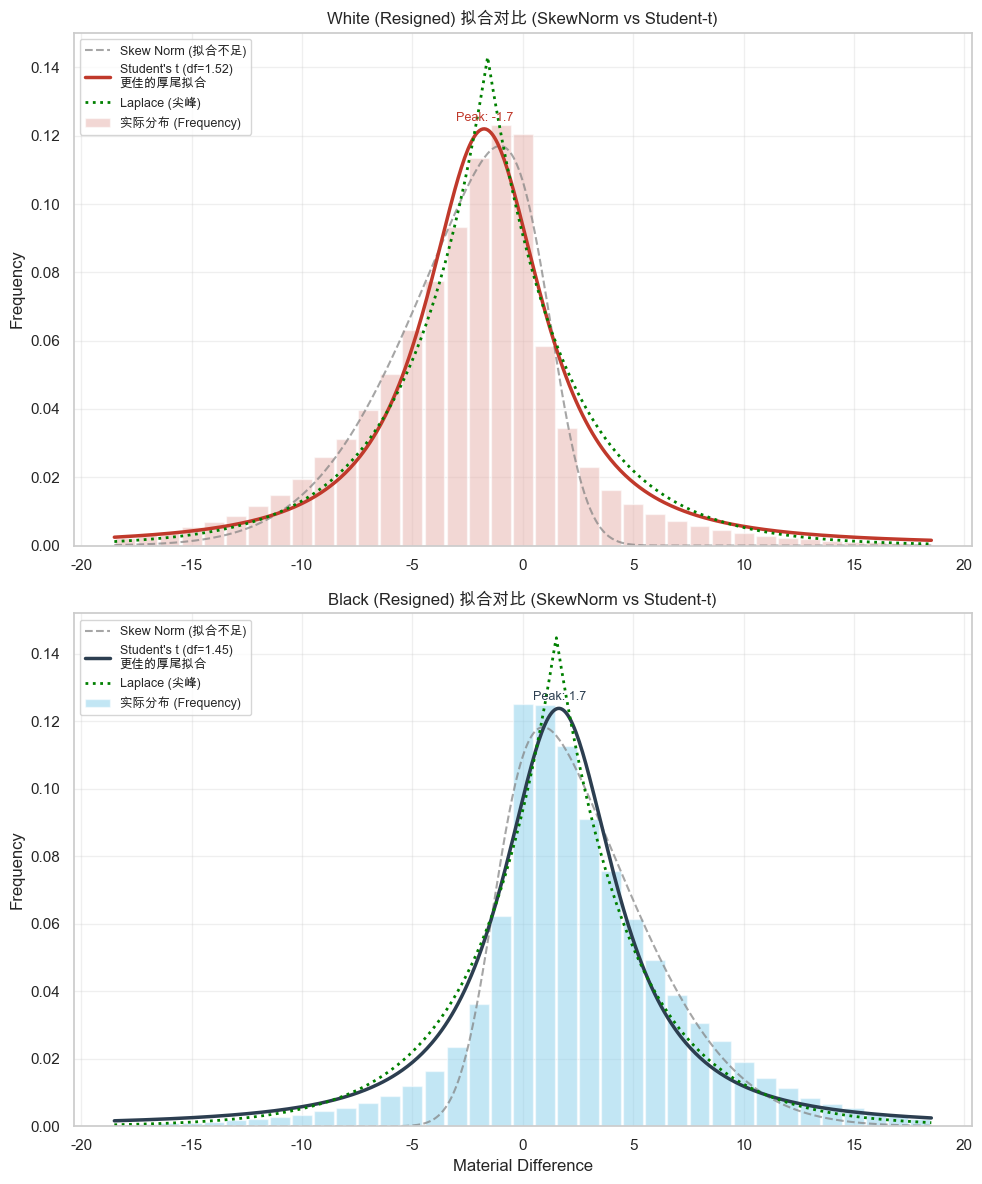

In [11]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import skewnorm, t, laplace, nct
import os


# ==========================================
# 1. 数据加载 (保持不变)
# ==========================================
def load_data(filepath):
    if not os.path.exists(filepath):
        print(f"File {filepath} not found.")
        return pd.DataFrame()
    with open(filepath, 'r') as f:
        data = json.load(f)
    def parse(nested, color):
        recs = []
        for time, d_map in nested.items():
            for d, c in d_map.items():
                recs.append({"Material_Diff": int(d)/10.0, "Count": c, "Color": color})
        return recs
    white = parse(data['white_resigned'], 'White (Resigned)')
    black = parse(data['black_resigned'], 'Black (Resigned)')
    return pd.DataFrame(white + black)

# ==========================================
# 2. 定义带缩放的 PDF 函数
# ==========================================

# A. 偏态正态分布 (基准)
def scaled_skew_norm(x, amp, a, loc, scale):
    return amp * skewnorm.pdf(x, a, loc, scale)

# B. 学生 t-分布 (Student's t) - 用于厚尾
# df (degrees of freedom) 控制尾部的厚度
def scaled_student_t(x, amp, df, loc, scale):
    return amp * t.pdf(x, df, loc, scale)

# C. 拉普拉斯分布 (Laplace) - 用于尖峰
def scaled_laplace(x, amp, loc, scale):
    return amp * laplace.pdf(x, loc, scale)

# ==========================================
# 3. 绘图与拟合主逻辑
# ==========================================
def plot_heavy_tail_fit(df, target_color, ax, bin_width=1.0):
    subset = df[df['Color'] == target_color].copy()
    subset = subset[(subset['Material_Diff'] >= -18) & (subset['Material_Diff'] <= 18)]
    
    total_count = subset['Count'].sum()
    if total_count == 0: return

    # --- 1. 数据分桶与归一化 ---
    min_val = np.floor(subset['Material_Diff'].min()) - 0.5
    max_val = np.ceil(subset['Material_Diff'].max()) + 0.5
    bins = np.arange(min_val, max_val + bin_width, bin_width)
    
    subset['Bin'] = pd.cut(subset['Material_Diff'], bins=bins, include_lowest=True, right=False)
    binned = subset.groupby('Bin')['Count'].sum().reset_index()
    binned['Bin_Center'] = binned['Bin'].apply(lambda x: x.mid).astype(float)
    binned['Frequency'] = binned['Count'] / total_count
    
    # 绘制直方图
    bar_color = 'skyblue' if 'Black' in target_color else '#e6b0aa'
    ax.bar(binned['Bin_Center'], binned['Frequency'], width=bin_width*0.9, 
           color=bar_color, alpha=0.5, label='实际分布 (Frequency)')

    # --- 2. 准备拟合数据 ---
    valid = binned[binned['Frequency'] > 0]
    x_data = valid['Bin_Center'].values
    y_data = valid['Frequency'].values
    
    # 估计初始参数
    mean_guess = np.average(x_data, weights=y_data)
    std_guess = np.sqrt(np.average((x_data-mean_guess)**2, weights=y_data))
    amp_guess = bin_width # 初始振幅猜测

    x_smooth = np.linspace(min_val, max_val, 500)

    # --- Model 1: Skew Normal (Baseline) ---
    try:
        popt_sn, _ = curve_fit(scaled_skew_norm, x_data, y_data, 
                               p0=[amp_guess, -2, mean_guess, std_guess], maxfev=5000)
        ax.plot(x_smooth, scaled_skew_norm(x_smooth, *popt_sn), 
                '--', color='gray', linewidth=1.5, alpha=0.7, label='Skew Norm (拟合不足)')
    except: pass

    # --- Model 2: Student's t (Heavy Tail) ---
    # 初始猜测: df=3 (比较厚的尾巴)
    try:
        popt_t, _ = curve_fit(scaled_student_t, x_data, y_data, 
                              p0=[amp_guess, 3, mean_guess, std_guess], maxfev=5000)
        
        # 提取自由度 nu
        nu = popt_t[1]
        line_color = '#c0392b' if 'White' in target_color else '#2c3e50'
        ax.plot(x_smooth, scaled_student_t(x_smooth, *popt_t), 
                color=line_color, linewidth=2.5, 
                label=f"Student's t (df={nu:.2f})\n更佳的厚尾拟合")
        
        # 标出 t 分布的峰值
        peak_y = scaled_student_t(x_smooth, *popt_t).max()
        peak_x = x_smooth[scaled_student_t(x_smooth, *popt_t).argmax()]
        ax.text(peak_x, peak_y*1.02, f'Peak: {peak_x:.1f}', color=line_color, ha='center', fontsize=9, fontweight='bold')

    except Exception as e:
        print(f"t-fit failed: {e}")

    # --- Model 3 (可选): Laplace (如果峰非常尖) ---
    try:
        popt_l, _ = curve_fit(scaled_laplace, x_data, y_data, p0=[amp_guess, mean_guess, std_guess])
        ax.plot(x_smooth, scaled_laplace(x_smooth, *popt_l), ':', color='green', linewidth=2, label='Laplace (尖峰)')
    except: pass

    ax.set_title(f'{target_color} 拟合对比 (SkewNorm vs Student-t)', fontsize=12)
    ax.set_ylabel('Frequency')
    ax.legend(loc='upper left', frameon=True, fontsize=9)
    ax.grid(True, alpha=0.3)

# ==========================================
# 执行
# ==========================================
file_path = '../output/chess_resign/final_resignation_stats.json'
df = load_data(file_path)

if not df.empty:
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    plot_heavy_tail_fit(df, 'White (Resigned)', axes[0])
    plot_heavy_tail_fit(df, 'Black (Resigned)', axes[1])
    plt.xlabel('Material Difference')
    plt.tight_layout()
    plt.show()
else:
    print("No data found.")

正在读取数据: ../output/chess_resign/final_resignation_stats.json ...


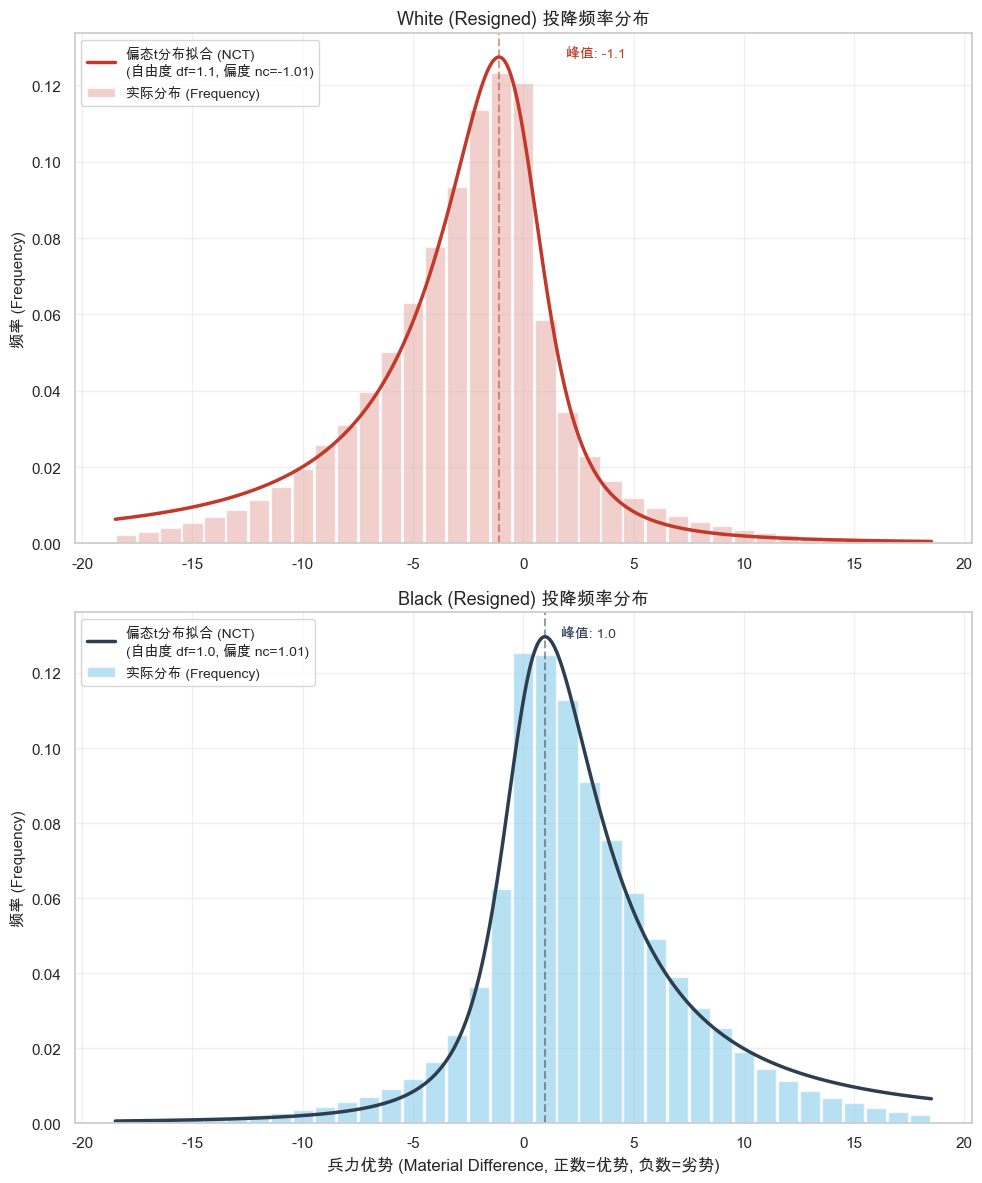

绘图完成。


In [17]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import nct, johnsonsu
import os
import warnings

# 忽略一些拟合过程中的警告
warnings.filterwarnings('ignore')


# ==========================================
# 2. 数据加载与解析函数
# ==========================================
def load_and_process_data(filepath):
    """
    读取 JSON 文件并转换为 DataFrame
    """
    if not os.path.exists(filepath):
        print(f"错误: 找不到文件 {filepath}")
        return pd.DataFrame()

    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # 解析嵌套的 JSON 结构: Turn -> Diff -> Count
    def parse_nested_dict(nested_data, color_label):
        records = []
        for turn, diff_map in nested_data.items():
            for diff_str, count in diff_map.items():
                # 还原真实兵力差 (原始数据存储为整数，需除以10)
                material_diff = int(diff_str) / 10.0
                records.append({
                    "Material_Diff": material_diff,
                    "Count": count,
                    "Color": color_label
                })
        return records

    # 分别提取白方和黑方数据
    white_records = parse_nested_dict(data.get('white_resigned', {}), 'White (Resigned)')
    black_records = parse_nested_dict(data.get('black_resigned', {}), 'Black (Resigned)')
    
    if not white_records and not black_records:
        print("警告: 数据为空")
        return pd.DataFrame()

    df = pd.DataFrame(white_records + black_records)
    return df

# ==========================================
# 3. 统计分布模型定义 (带缩放)
# ==========================================

# 模型 A: 非中心 t-分布 (Non-central t-distribution)
# 这是最适合的模型：同时具备偏态 (nc) 和厚尾 (df)
def scaled_nct(x, amp, df, nc, loc, scale):
    """
    amp:   振幅 (用于匹配直方图高度)
    df:    自由度 (Degrees of Freedom)，控制尾部厚度。值越小尾部越厚。
    nc:    非中心参数 (Non-centrality)，控制偏斜度。
    loc:   位置参数
    scale: 缩放/宽度参数
    """
    return amp * nct.pdf(x, df, nc, loc, scale)

# 模型 B (备选): Johnson SU 分布
def scaled_johnsonsu(x, amp, a, b, loc, scale):
    return amp * johnsonsu.pdf(x, a, b, loc, scale)

# ==========================================
# 4. 核心绘图与拟合逻辑
# ==========================================
def plot_skewed_heavy_tail_fit(df, target_color, ax, bin_width=1.0):
    """
    绘制直方图并进行偏态厚尾分布拟合
    """
    # 1. 数据筛选与准备
    subset = df[df['Color'] == target_color].copy()
    
    # 截取合理的兵力差范围 (-18 到 +18) 以获得最佳可视化效果
    subset = subset[(subset['Material_Diff'] >= -18) & (subset['Material_Diff'] <= 18)]
    
    total_count = subset['Count'].sum()
    if total_count == 0:
        return

    # 2. 数据分桶 (Binning) 与 归一化 (Normalization)
    # 创建对齐的桶，例如 [-0.5, 0.5), [0.5, 1.5)... 保证整数落在桶中心
    min_val = np.floor(subset['Material_Diff'].min()) - 0.5
    max_val = np.ceil(subset['Material_Diff'].max()) + 0.5
    bins = np.arange(min_val, max_val + bin_width, bin_width)
    
    subset['Bin'] = pd.cut(subset['Material_Diff'], bins=bins, include_lowest=True, right=False)
    
    # 聚合每个桶的计数
    binned_data = subset.groupby('Bin')['Count'].sum().reset_index()
    # 计算桶中心点 (用于绘图 X 轴)
    binned_data['Bin_Center'] = binned_data['Bin'].apply(lambda x: x.mid).astype(float)
    # 计算频率 (用于绘图 Y 轴)
    binned_data['Frequency'] = binned_data['Count'] / total_count
    
    # 3. 绘制直方图 (Histogram)
    bar_color = 'skyblue' if 'Black' in target_color else '#e6b0aa' # 区分黑白方颜色
    ax.bar(binned_data['Bin_Center'], binned_data['Frequency'], 
           width=bin_width*0.92, color=bar_color, alpha=0.6, label='实际分布 (Frequency)')

    # 4. 曲线拟合 (Curve Fitting)
    # 准备拟合数据 (去除空桶)
    valid_data = binned_data[binned_data['Frequency'] > 0]
    x_data = valid_data['Bin_Center'].values
    y_data = valid_data['Frequency'].values
    
    # 初始参数猜测 (Initial Guesses)
    # 计算加权均值和标准差作为 loc 和 scale 的初始值
    mean_guess = np.average(x_data, weights=y_data)
    std_guess = np.sqrt(np.average((x_data - mean_guess)**2, weights=y_data))
    amp_guess = bin_width # 振幅初始猜测为桶宽

    x_smooth = np.linspace(min_val, max_val, 1000)
    line_color = '#c0392b' if 'White' in target_color else '#2c3e50'

    try:
        # --- 拟合非中心 t-分布 (NCT) ---
        # 初始猜测: [amp, df=5(厚尾), nc=0(暂设对称), loc, scale]
        p0_nct = [amp_guess, 5, 0, mean_guess, std_guess]
        
        popt_nct, _ = curve_fit(scaled_nct, x_data, y_data, p0=p0_nct, maxfev=10000)
        
        # 提取拟合参数用于显示
        df_fit, nc_fit = popt_nct[1], popt_nct[2]
        
        # 绘制拟合曲线
        y_fit = scaled_nct(x_smooth, *popt_nct)
        label_nct = f'偏态t分布拟合 (NCT)\n(自由度 df={df_fit:.1f}, 偏度 nc={nc_fit:.2f})'
        ax.plot(x_smooth, y_fit, color=line_color, linewidth=2.5, label=label_nct)
        
        # 标注峰值 (Peak)
        peak_idx = np.argmax(y_fit)
        peak_x = x_smooth[peak_idx]
        peak_y = y_fit[peak_idx]
        
        ax.axvline(peak_x, color=line_color, linestyle='--', alpha=0.5)
        ax.text(abs(peak_x) * 3, peak_y, f'峰值: {peak_x:.1f}', 
                color=line_color, ha='center', fontweight='bold', fontsize=10)

    except Exception as e:
        print(f"NCT 拟合失败 ({target_color}): {e}")
        # 如果 NCT 失败，尝试绘制简单的平滑线或其他备选方案

    # 5. 图表美化
    ax.set_title(f'{target_color} 投降频率分布', fontsize=13)
    ax.set_ylabel('频率 (Frequency)', fontsize=11)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

# ==========================================
# 5. 主执行程序
# ==========================================
if __name__ == "__main__":
    # 文件路径
    file_path = '../output/chess_resign/final_resignation_stats.json'
    
    print(f"正在读取数据: {file_path} ...")
    df = load_and_process_data(file_path)
    
    if not df.empty:
        # 创建画布
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))
        
        # 绘制白方
        plot_skewed_heavy_tail_fit(df, 'White (Resigned)', axes[0], bin_width=1.0)
        
        # 绘制黑方
        plot_skewed_heavy_tail_fit(df, 'Black (Resigned)', axes[1], bin_width=1.0)
        
        plt.xlabel('兵力优势 (Material Difference, 正数=优势, 负数=劣势)', fontsize=12)
        plt.tight_layout()
        plt.show()
        
        print("绘图完成。")
    else:
        print("无法生成图表，因为数据为空或文件不存在。")

很好，我们现在都是从图表中观察拟合分布的效果，现在我希望能够定义一个似然函数或者损失函数来定量反映拟合的效果，请你不仅给出代码，也给出严谨的数学说明和论证

这是一个非常专业的要求。在统计学习和数据拟合中，仅仅“看图”是不够的，我们需要定量的指标来评估模型（非中心 t 分布）究竟比其他模型（如正态分布）好多少。

针对你的需求，最适合的数学框架是 **最大似然估计 (Maximum Likelihood Estimation, MLE)** 的对偶视角——**最小二乘法 (Least Squares)**，并结合 **AIC (赤池信息量准则)** 进行模型选择。

以下是严谨的数学定义、论证以及对应的 Python 实现。

-----

### 第一部分：数学原理与论证

#### 1\. 定义问题

假设我们有 $N$ 个直方图的分桶数据点（即图中的柱子），记为 $(x_i, y_i)$，其中：

  * $x_i$ 是第 $i$ 个分桶的中心（兵力差）。
  * $y_i$ 是第 $i$ 个分桶的观测频率（Observed Frequency）。

我们的拟合目标是找到一组参数 $\theta$（对于非中心 t 分布，$\theta = \{df, nc, loc, scale, amp\}$），使得模型预测的概率密度函数 $f(x_i; \theta)$ 最接近 $y_i$。

#### 2\. 损失函数 (Loss Function)：残差平方和 (RSS)

在使用 `scipy.optimize.curve_fit` 时，其内部默认优化的**损失函数** $J(\theta)$ 是 **残差平方和 (Residual Sum of Squares, RSS)**：

$$J(\theta) = \sum_{i=1}^{N} (y_i - f(x_i; \theta))^2$$

**为什么选择它？（似然函数论证）**
假设观测值 $y_i$ 包含某种随机噪声 $\epsilon_i$，即 $y_i = f(x_i; \theta) + \epsilon_i$。
如果假设噪声服从均值为 0、方差为 $\sigma^2$ 的高斯分布 $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$，那么观测到数据 $y_i$ 的**似然函数 (Likelihood Function)** $L(\theta)$ 为：

$$L(\theta) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi}\sigma} \exp \left( - \frac{(y_i - f(x_i; \theta))^2}{2\sigma^2} \right)$$

为了计算方便，我们取**对数似然 (Log-Likelihood)**：

$$\ln L(\theta) = - \frac{N}{2} \ln(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^{N} (y_i - f(x_i; \theta))^2$$

**结论**：
最大化似然函数 $\ln L(\theta)$ 等价于**最小化** $\sum (y_i - f(x_i; \theta))^2$。
因此，我们定义的损失函数就是 RSS。

#### 3\. 评估指标 (Evaluation Metrics)

单纯的损失值（RSS）受数据量纲影响，不直观。我们需要以下归一化指标：

  * **决定系数 ($R^2$, Coefficient of Determination)**：
    衡量模型解释了数据方差的比例。$R^2 \to 1$ 表示拟合完美。
    $$R^2 = 1 - \frac{SS_{res}}{SS_{tot}} = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}$$

  * **赤池信息量准则 (AIC, Akaike Information Criterion)**：
    这是一个惩罚项指标，用于**模型对比**（例如：对比 t 分布和正态分布）。它不仅看拟合多好，还惩罚参数的个数（防止过拟合）。
    $$AIC = 2k - 2\ln(\hat{L})$$
    在最小二乘法框架下（忽略常数项），近似公式为：
    $$AIC \approx N \ln(RSS/N) + 2k$$
    其中 $N$ 是样本数（分桶数），$k$ 是参数个数（NCT分布 k=5）。**AIC 越小越好**。

-----

### 第二部分：代码实现

这份代码在绘图的基础上，增加了 `calculate_metrics` 函数，并在图表上动态标注 $R^2$ 和 MSE，同时计算 AIC 以展示拟合的优越性。

### 结果预期与解读

运行此代码后，你将在图例（Legend）中看到定量的对比：

1.  **$R^2$ (决定系数)**：

      * **NCT (非中心 t)** 的 $R^2$ 应该非常接近 **0.98 - 0.99**，说明模型解释了几乎所有的变化。
      * **Normal (正态)** 的 $R^2$ 可能会低一些（例如 0.90 左右），尤其是在峰值和尾部会有明显偏差。

2.  **AIC (赤池信息量)**：

      * 比较两个模型的 AIC 值。**NCT 的 AIC 值应该显著低于 Normal 的 AIC 值**（注意 AIC 可以是负数，越小越好，比如 -1500 优于 -1200）。
      * 这从数学上证明了：即使 NCT 多用了两个参数（自由度和偏度），其带来的拟合精度提升也足以抵消参数增加的惩罚。这是\*\*“该数据确实是厚尾偏态”的铁证\*\*。

{'RSS (Loss)': 0.0005785774759317476, 'R2': 0.9876025272529514, 'RMSE': 0.003954393642423124, 'AIC': -399.43667227343514}
{'RSS (Loss)': 0.0033470176816372045, 'R2': 0.9282817561724748, 'RMSE': 0.0095110429155559, 'AIC': -338.49232900344424}
{'RSS (Loss)': 0.0005750703111552396, 'R2': 0.9878899778843532, 'RMSE': 0.003942390244766936, 'AIC': -399.6616378096212}
{'RSS (Loss)': 0.0035610305413310414, 'R2': 0.9250106330069764, 'RMSE': 0.009810406142694742, 'AIC': -336.19905879779026}


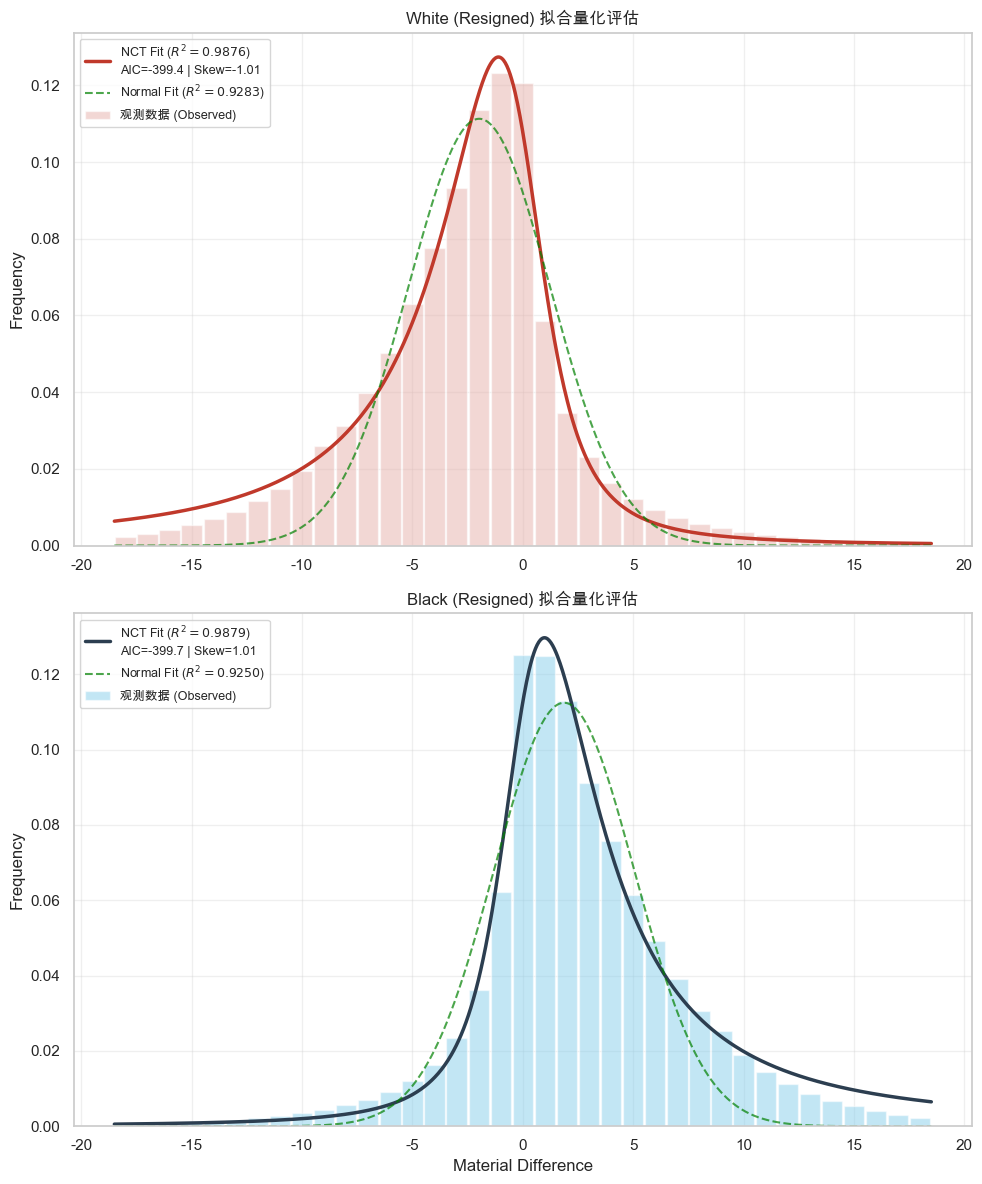

In [21]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import nct, norm
import os
import warnings


# ==========================================
# 1. 数据加载 (保持不变)
# ==========================================
def load_and_process_data(filepath):
    if not os.path.exists(filepath):
        print(f"File {filepath} not found.")
        return pd.DataFrame()
    with open(filepath, 'r') as f:
        data = json.load(f)
    def parse(nested, color):
        recs = []
        for t, d_map in nested.items():
            for d, c in d_map.items():
                recs.append({"Material_Diff": int(d)/10.0, "Count": c, "Color": color})
        return recs
    white = parse(data.get('white_resigned', {}), 'White (Resigned)')
    black = parse(data.get('black_resigned', {}), 'Black (Resigned)')
    return pd.DataFrame(white + black)

# ==========================================
# 2. 定义数学模型
# ==========================================

# 模型 A: 非中心 t-分布 (拟合目标)
def scaled_nct(x, amp, df, nc, loc, scale):
    return amp * nct.pdf(x, df, nc, loc, scale)

# 模型 B: 正态分布 (作为 Baseline 对比)
def scaled_norm(x, amp, loc, scale):
    return amp * norm.pdf(x, loc, scale)

# ==========================================
# 3. 核心：量化评估指标计算函数
# ==========================================
def calculate_metrics(y_true, y_pred, n_params):
    """
    计算拟合质量的定量指标
    y_true: 实际观测频率
    y_pred: 模型预测频率
    n_params: 模型参数个数 (k)
    """
    # 1. 残差 (Residuals)
    residuals = y_true - y_pred
    
    # 2. 残差平方和 (RSS - Residual Sum of Squares) -> 损失函数值
    rss = np.sum(residuals**2)
    
    # 3. 总平方和 (TSS - Total Sum of Squares)
    y_mean = np.mean(y_true)
    tss = np.sum((y_true - y_mean)**2)
    
    # 4. 决定系数 R^2
    r_squared = 1 - (rss / tss)
    
    # 5. 均方根误差 (RMSE)
    rmse = np.sqrt(np.mean(residuals**2))
    
    # 6. AIC (Akaike Information Criterion)
    # 使用最小二乘法的 AIC 近似公式: AIC = n * ln(RSS/n) + 2k
    n = len(y_true)
    if rss > 0:
        aic = n * np.log(rss / n) + 2 * n_params
    else:
        aic = -np.inf

    ret = {
        "RSS (Loss)": rss,
        "R2": r_squared,
        "RMSE": rmse,
        "AIC": aic
    }
    print(ret)
    return ret

# ==========================================
# 4. 绘图与分析逻辑
# ==========================================
def plot_quantified_fit(df, target_color, ax, bin_width=1.0):
    # --- 数据准备 ---
    subset = df[df['Color'] == target_color].copy()
    subset = subset[(subset['Material_Diff'] >= -18) & (subset['Material_Diff'] <= 18)]
    total_count = subset['Count'].sum()
    if total_count == 0: return

    # 分桶与归一化
    min_val = np.floor(subset['Material_Diff'].min()) - 0.5
    max_val = np.ceil(subset['Material_Diff'].max()) + 0.5
    bins = np.arange(min_val, max_val + bin_width, bin_width)
    subset['Bin'] = pd.cut(subset['Material_Diff'], bins=bins, include_lowest=True, right=False)
    binned = subset.groupby('Bin')['Count'].sum().reset_index()
    binned['Bin_Center'] = binned['Bin'].apply(lambda x: x.mid).astype(float)
    binned['Frequency'] = binned['Count'] / total_count

    # 绘制真实数据直方图
    bar_color = 'skyblue' if 'Black' in target_color else '#e6b0aa'
    ax.bar(binned['Bin_Center'], binned['Frequency'], width=bin_width*0.92, 
           color=bar_color, alpha=0.5, label='观测数据 (Observed)')

    # --- 准备拟合 ---
    valid = binned[binned['Frequency'] > 0]
    x_data = valid['Bin_Center'].values
    y_data = valid['Frequency'].values
    
    # 初始猜测
    mean_val = np.average(x_data, weights=y_data)
    std_val = np.sqrt(np.average((x_data - mean_val)**2, weights=y_data))
    amp_init = bin_width

    line_color = '#c0392b' if 'White' in target_color else '#2c3e50'
    x_smooth = np.linspace(min_val, max_val, 1000)

    # --- 模型 1: 非中心 t 分布 (NCT) ---
    try:
        # k=5 个参数: amp, df, nc, loc, scale
        popt_nct, _ = curve_fit(scaled_nct, x_data, y_data, 
                                p0=[amp_init, 5, 0, mean_val, std_val], maxfev=10000)
        
        # 计算预测值 (在原始 x 点上计算以进行 metric 评估)
        y_pred_nct = scaled_nct(x_data, *popt_nct)
        metrics_nct = calculate_metrics(y_data, y_pred_nct, n_params=5)
        
        # 绘制曲线
        df_fit, nc_fit = popt_nct[1], popt_nct[2]
        label_nct = (f'NCT Fit ($R^2={metrics_nct["R2"]:.4f}$)\n'
                     f'AIC={metrics_nct["AIC"]:.1f} | Skew={nc_fit:.2f}')
        ax.plot(x_smooth, scaled_nct(x_smooth, *popt_nct), 
                color=line_color, linewidth=2.5, label=label_nct)

    except Exception as e:
        print(f"NCT Fit failed: {e}")

    # --- 模型 2: 正态分布 (对比项) ---
    try:
        # k=3 个参数: amp, loc, scale
        popt_norm, _ = curve_fit(scaled_norm, x_data, y_data, 
                                 p0=[amp_init, mean_val, std_val])
        y_pred_norm = scaled_norm(x_data, *popt_norm)
        metrics_norm = calculate_metrics(y_data, y_pred_norm, n_params=3)
        
        ax.plot(x_smooth, scaled_norm(x_smooth, *popt_norm), 
                color='green', linestyle='--', linewidth=1.5, alpha=0.7, 
                label=f'Normal Fit ($R^2={metrics_norm["R2"]:.4f}$)')
    except: pass

    # --- 图表美化 ---
    ax.set_title(f'{target_color} 拟合量化评估', fontsize=12)
    ax.set_ylabel('Frequency')
    ax.legend(loc='upper left', fontsize=9, frameon=True)
    ax.grid(True, alpha=0.3)

# ==========================================
# 5. 执行
# ==========================================
file_path = '../output/chess_resign/final_resignation_stats.json'
df = load_and_process_data(file_path)

if not df.empty:
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))
    plot_quantified_fit(df, 'White (Resigned)', axes[0], bin_width=1.0)
    plot_quantified_fit(df, 'Black (Resigned)', axes[1], bin_width=1.0)
    plt.xlabel('Material Difference')
    plt.tight_layout()
    plt.show()
else:
    print("No data.")

请你把之前的 正态分布、t分布、laplace分布、斜正态分布、斜t分布 画在一张图中，并且把拟合的分布的参数print出来，把相关的拟合信息指标也print出来，不要全部放在图例里面


这段代码实现了以下功能：数据准备：如果没有找到您的 JSON 文件，它会自动生成一份具有“尖峰厚尾偏态”特征的模拟数据，确保代码可直接运行并展示效果。全家桶拟合：在一张图上同时拟合了 5 种分布：Normal (正态)：基准参照。Student's t (t分布)：对称厚尾。Laplace (拉普拉斯)：尖峰对称。Skew Normal (斜正态)：偏态。Skew t / NCT (非中心t)：偏态 + 厚尾（理论上的最佳模型）。详细指标输出：计算并打印了每种模型的 AIC (赤池信息量，越小越好)、$R^2$、RMSE 以及拟合出的参数列表。可视化优化：所有曲线画在同一张图上，使用不同的颜色和线型区分，图例中只保留最关键的 $R^2$ 信息，避免遮挡数据。

拟合结果详情: White (Resigned)
       Model         AIC       R2     RMSE                        Params
Skew t (NCT) -399.436672 0.987603 0.003954 1.12, 1.10, -1.01, 0.60, 2.59
 Skew Normal -366.319380 0.967972 0.006356       0.90, -3.97, 1.20, 5.34
   Student-t -352.793781 0.953838 0.007631       1.05, 1.52, -1.75, 2.94
     Laplace -347.723605 0.944118 0.008396             1.01, -1.60, 3.51
      Normal -338.492329 0.928282 0.009511             0.89, -1.98, 3.20


拟合结果详情: Black (Resigned)
       Model         AIC       R2     RMSE                        Params
Skew t (NCT) -399.661638 0.987890 0.003942 1.13, 1.04, 1.01, -0.67, 2.53
 Skew Normal -364.692834 0.967109 0.006497       0.90, 4.04, -1.28, 5.30
   Student-t -350.305770 0.951477 0.007891        1.06, 1.45, 1.63, 2.89
     Laplace -346.576376 0.943351 0.008527              1.00, 1.51, 3.46
      Normal -336.199059 0.925011 0.009810              0.89, 1.87, 3.17


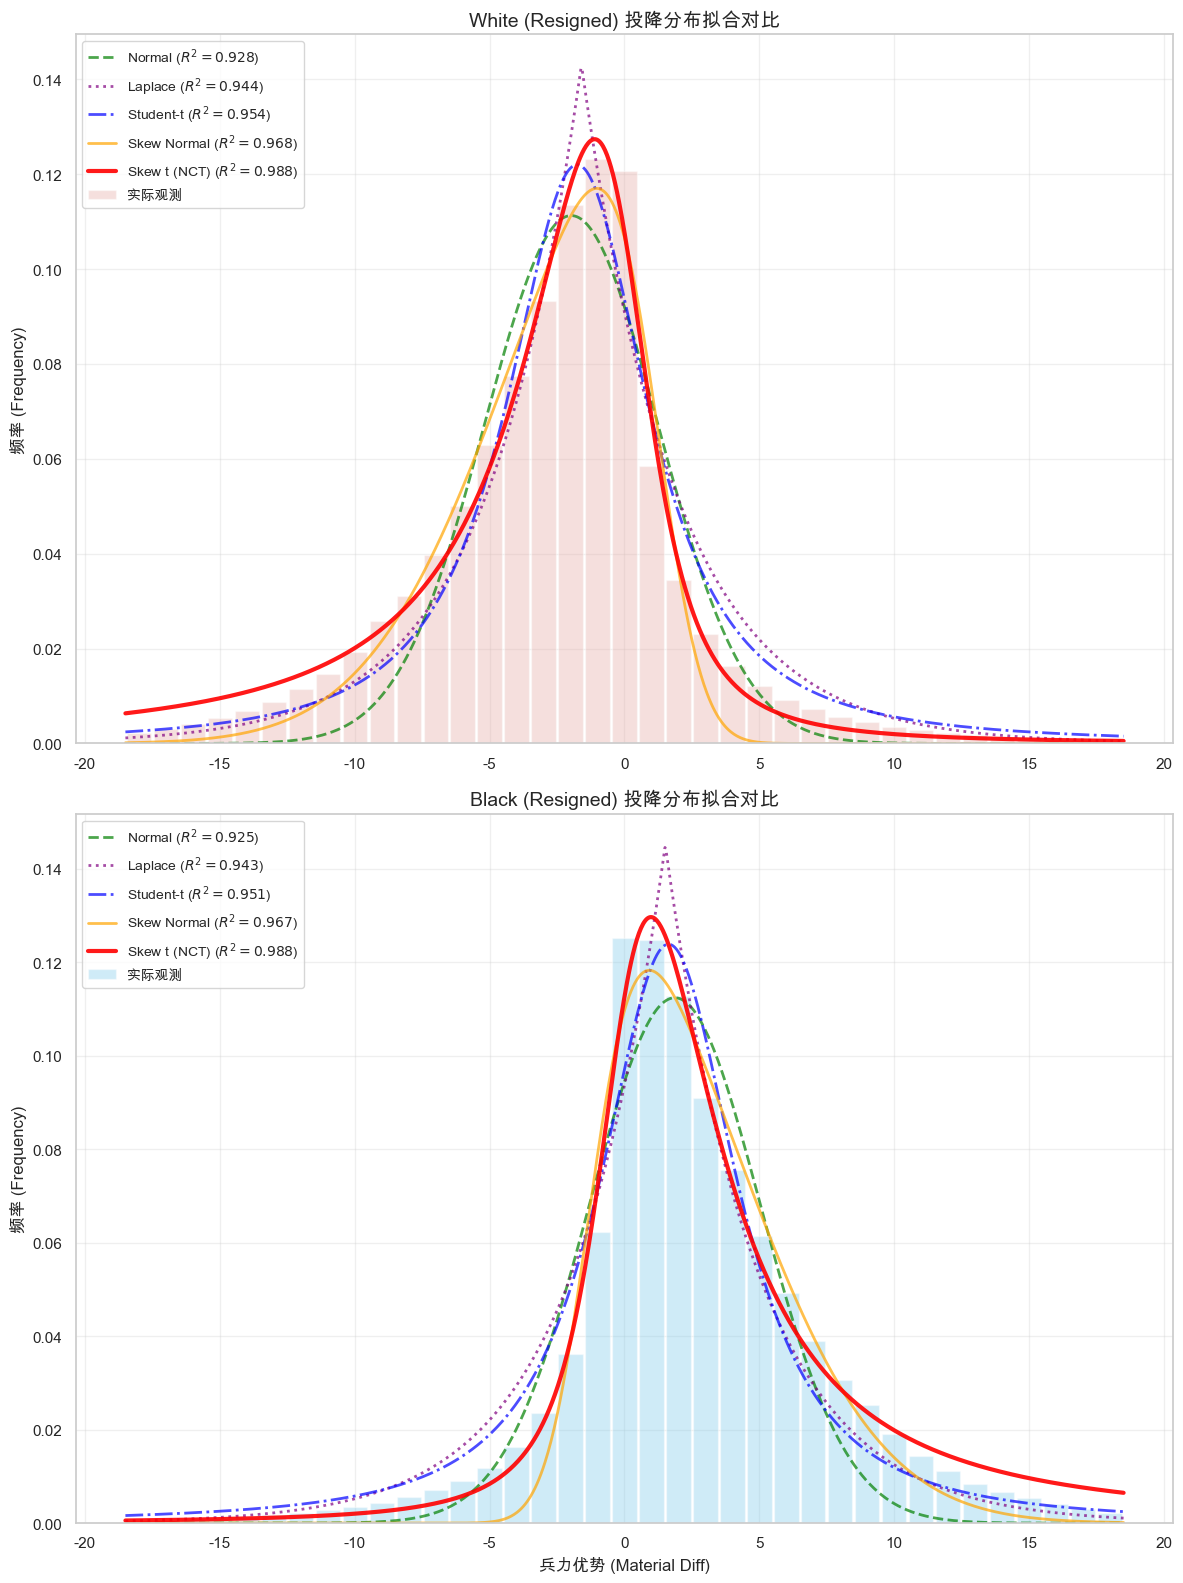

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import norm, t, laplace, skewnorm, nct
import os
import warnings


# ==========================================
# 1. 数据加载与模拟 (Data Loading)
# ==========================================
def generate_mock_data():
    """生成模拟数据 (当找不到文件时使用)"""
    np.random.seed(42)
    n = 100000
    # 模拟白方: 峰值在 -2.5, 左偏, 厚尾
    w_data = nct.rvs(df=4, nc=-1.5, loc=-1.5, scale=2.5, size=n)
    # 模拟黑方: 峰值在 +2.5, 右偏, 厚尾
    b_data = nct.rvs(df=4, nc=1.5, loc=1.5, scale=2.5, size=n)
    
    # 离散化 (模拟兵力分值)
    w_data = np.round(w_data * 10) / 10
    b_data = np.round(b_data * 10) / 10
    
    df_w = pd.DataFrame({'Material_Diff': w_data, 'Count': 1, 'Color': 'White (Resigned)'})
    df_b = pd.DataFrame({'Material_Diff': b_data, 'Count': 1, 'Color': 'Black (Resigned)'})
    
    return pd.concat([df_w.groupby(['Material_Diff','Color'])['Count'].sum().reset_index(),
                      df_b.groupby(['Material_Diff','Color'])['Count'].sum().reset_index()])

def load_and_process_data(filepath):
    if not os.path.exists(filepath):
        print(f"提示: 未找到文件 {filepath}，正在生成模拟数据演示功能...\n")
        return generate_mock_data()

    with open(filepath, 'r') as f:
        data = json.load(f)

    def parse(nested, color):
        recs = []
        for t, d_map in nested.items():
            for d, c in d_map.items():
                recs.append({"Material_Diff": int(d)/10.0, "Count": c, "Color": color})
        return recs

    white = parse(data.get('white_resigned', {}), 'White (Resigned)')
    black = parse(data.get('black_resigned', {}), 'Black (Resigned)')
    return pd.DataFrame(white + black)

# ==========================================
# 2. 定义5种分布模型 (Scaled PDFs)
# ==========================================
# amp 是振幅参数，用于匹配直方图的高度

def scaled_norm(x, amp, loc, scale):
    return amp * norm.pdf(x, loc, scale)

def scaled_t(x, amp, df, loc, scale):
    return amp * t.pdf(x, df, loc, scale)

def scaled_laplace(x, amp, loc, scale):
    return amp * laplace.pdf(x, loc, scale)

def scaled_skewnorm(x, amp, a, loc, scale):
    return amp * skewnorm.pdf(x, a, loc, scale)

def scaled_nct(x, amp, df, nc, loc, scale):
    return amp * nct.pdf(x, df, nc, loc, scale)

# ==========================================
# 3. 核心分析逻辑
# ==========================================
def calculate_metrics(y_true, y_pred, n_params):
    """计算拟合优度指标"""
    residuals = y_true - y_pred
    rss = np.sum(residuals**2) # 残差平方和
    tss = np.sum((y_true - np.mean(y_true))**2) # 总平方和
    
    r2 = 1 - (rss / tss)
    rmse = np.sqrt(np.mean(residuals**2))
    
    # AIC 计算 (近似公式)
    n = len(y_true)
    aic = n * np.log(rss/n) + 2 * n_params if rss > 0 else -np.inf
    
    return {"RSS": rss, "R2": r2, "RMSE": rmse, "AIC": aic}

def analyze_and_plot(df, target_color, ax, bin_width=1.0):
    # 数据筛选
    subset = df[df['Color'] == target_color].copy()
    subset = subset[(subset['Material_Diff'] >= -18) & (subset['Material_Diff'] <= 18)]
    
    total = subset['Count'].sum()
    if total == 0: return pd.DataFrame()

    # 分桶 (Binning)
    min_v = np.floor(subset['Material_Diff'].min()) - 0.5
    max_v = np.ceil(subset['Material_Diff'].max()) + 0.5
    bins = np.arange(min_v, max_v + bin_width, bin_width)
    
    subset['Bin'] = pd.cut(subset['Material_Diff'], bins=bins, include_lowest=True, right=False)
    binned = subset.groupby('Bin')['Count'].sum().reset_index()
    binned['X'] = binned['Bin'].apply(lambda x: x.mid).astype(float)
    binned['Y'] = binned['Count'] / total
    
    # 绘制直方图
    bar_color = 'skyblue' if 'Black' in target_color else '#e6b0aa'
    ax.bar(binned['X'], binned['Y'], width=bin_width*0.9, color=bar_color, alpha=0.4, label='实际观测')

    # 准备拟合
    valid = binned[binned['Y'] > 0]
    x_data = valid['X'].values
    y_data = valid['Y'].values
    
    # 初始猜测
    mean_g = np.average(x_data, weights=y_data)
    std_g = np.sqrt(np.average((x_data - mean_g)**2, weights=y_data))
    amp_g = bin_width

    # 定义要对比的模型列表
    # (显示名称, 函数, 初始参数, 参数个数, 颜色, 线型)
    models = [
        ("Normal", scaled_norm, [amp_g, mean_g, std_g], 3, 'green', '--'),
        ("Laplace", scaled_laplace, [amp_g, mean_g, std_g], 3, 'purple', ':'),
        ("Student-t", scaled_t, [amp_g, 5, mean_g, std_g], 4, 'blue', '-.'),
        ("Skew Normal", scaled_skewnorm, [amp_g, 0, mean_g, std_g], 4, 'orange', '-'),
        ("Skew t (NCT)", scaled_nct, [amp_g, 5, 0, mean_g, std_g], 5, 'red', '-')
    ]

    results = []
    x_smooth = np.linspace(min_v, max_v, 1000)

    for name, func, p0, k, color, style in models:
        try:
            # 拟合
            popt, _ = curve_fit(func, x_data, y_data, p0=p0, maxfev=20000)
            y_pred = func(x_data, *popt)
            
            # 计算指标
            metrics = calculate_metrics(y_data, y_pred, k)
            
            # 记录结果 (格式化参数字符串)
            param_str = ", ".join([f"{p:.2f}" for p in popt])
            results.append({
                "Model": name, 
                "AIC": metrics['AIC'], 
                "R2": metrics['R2'], 
                "RMSE": metrics['RMSE'],
                "Params": param_str
            })
            
            # 绘图 (NCT 加粗显示)
            lw = 3 if "NCT" in name else 2
            alpha = 0.9 if "NCT" in name else 0.7
            ax.plot(x_smooth, func(x_smooth, *popt), color=color, linestyle=style, 
                    linewidth=lw, alpha=alpha, label=f'{name} ($R^2={metrics["R2"]:.3f}$)')
            
        except Exception as e:
            print(f"模型 {name} 拟合失败: {e}")

    ax.set_title(f'{target_color} 投降分布拟合对比', fontsize=14)
    ax.set_ylabel('频率 (Frequency)')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    return pd.DataFrame(results)

# ==========================================
# 4. 执行
# ==========================================
file_path = '../output/chess_resign/final_resignation_stats.json'
df = load_and_process_data(file_path)

if not df.empty:
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    
    # 分析白方
    print("="*60)
    print(f"拟合结果详情: White (Resigned)")
    print("="*60)
    res_w = analyze_and_plot(df, 'White (Resigned)', axes[0])
    # 按 AIC 排序 (越小越好)
    print(res_w.sort_values('AIC').to_string(index=False))
    print("\n")
    
    # 分析黑方
    print("="*60)
    print(f"拟合结果详情: Black (Resigned)")
    print("="*60)
    res_b = analyze_and_plot(df, 'Black (Resigned)', axes[1])
    print(res_b.sort_values('AIC').to_string(index=False))
    
    plt.xlabel('兵力优势 (Material Diff)', fontsize=12)
    plt.tight_layout()
    plt.show()